## QH9 Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.deeporb.default_net import default_net_task, default_data
chkpt = "/home/king1305/ORBITAL_LABELING/deeporb2/model_eval/b3lyp_occ/version_0/checkpoints/epoch=749-step=300000.ckpt"
occ_data_name = "b3lyp_occ"
occ_task,occ_data = default_net_task(mean_std=occ_data_name,chkpt=chkpt)
occ_task.model.cuda();
occ_task.model.eval();

Loading model from /home/king1305/ORBITAL_LABELING/deeporb2/model_eval/b3lyp_occ/version_0/checkpoints/epoch=749-step=300000.ckpt ...
Loading successful!


In [5]:
from src.deeporb.default_net import default_net_task, default_data
chkpt = "/home/king1305/ORBITAL_LABELING/deeporb2/model_eval/b3lyp_virt/version_0/checkpoints/epoch=749-step=300000.ckpt"
virt_data_name = "b3lyp_virt"
virt_task,virt_data = default_net_task(mean_std=virt_data_name,chkpt=chkpt)
virt_task.model.cuda();
virt_task.model.eval();

Loading model from /home/king1305/ORBITAL_LABELING/deeporb2/model_eval/b3lyp_virt/version_0/checkpoints/epoch=749-step=300000.ckpt ...
Loading successful!


In [6]:
import torch
import numpy as np
from deeporb.default_net import mean_std_dct
AVGE0, SIGMA = mean_std_dct[occ_data_name]
pred_energies = []
true_energies = []
with torch.no_grad():
    for batch in occ_data.test_dataloader():
        batch.cuda()
        out = occ_task.model(batch)
        pred_energy = out["pred_energy"] * SIGMA + AVGE0
        pred_energy = pred_energy.cpu().detach().numpy()
        pred_energies.append(pred_energy)
        true_energy = batch["energy"].cpu().detach().numpy()
        true_energies.append(true_energy)
        # break
pred_energies = np.hstack(pred_energies)
true_energies = np.hstack(true_energies)
occ_pred = pred_energies
occ_true = true_energies

In [7]:
import torch
import numpy as np
from deeporb.default_net import mean_std_dct
AVGE0, SIGMA = mean_std_dct[virt_data_name]
pred_energies = []
true_energies = []
with torch.no_grad():
    for batch in virt_data.test_dataloader():
        batch.cuda()
        out = virt_task.model(batch)
        pred_energy = out["pred_energy"] * SIGMA + AVGE0
        pred_energy = pred_energy.cpu().detach().numpy()
        pred_energies.append(pred_energy)
        true_energy = batch["energy"].cpu().detach().numpy()
        true_energies.append(true_energy)
        # break
pred_energies = np.hstack(pred_energies)
true_energies = np.hstack(true_energies)
virt_pred = pred_energies
virt_true = true_energies

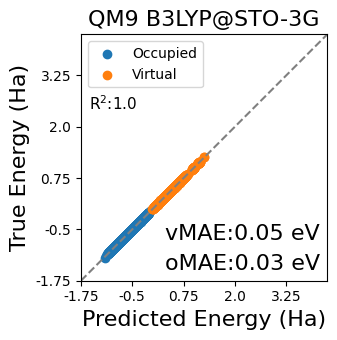

In [8]:
import scipy
import matplotlib.pyplot as plt
plt.figure(figsize=(3.5,3.5))
plt.scatter(occ_pred,occ_true,label="Occupied")
plt.scatter(virt_pred,virt_true,label="Virtual")
hartree_to_ev = 27.2114
tot_pred = np.hstack([occ_pred,virt_pred])
tot_true = np.hstack([occ_true,virt_true])
occ_mae = np.abs(occ_pred - occ_true).mean()
virt_mae = np.abs(virt_pred - virt_true).mean()
mae = np.abs(pred_energies - true_energies).mean()
mae = np.round(mae*hartree_to_ev,2)
occ_mae = np.round(occ_mae*hartree_to_ev,2)
virt_mae = np.round(virt_mae*hartree_to_ev,2)
r2 = np.round(scipy.stats.pearsonr(tot_pred,tot_true)[0],3)
xmin, xmax = -1.75, 4.25
s = 1.25
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
tcks = np.round(np.arange(xmin,xmax,s),2)
plt.xticks(tcks,tcks)
plt.yticks(tcks,tcks)
plt.gca().set_aspect('equal')
plt.legend()
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.xlabel("Predicted Energy (Ha)",fontsize=fs,**djvfont)
plt.ylabel("True Energy (Ha)",fontsize=fs,**djvfont)
plt.title("QM9 B3LYP@STO-3G",fontsize=fs,**djvfont)
plt.text(-1.55,2.4,f"R$^2$:{r2}",fontsize=11,**djvfont)
plt.text(0.3,-0.75,f"vMAE:{virt_mae} eV",fontsize=fs,**djvfont)
plt.text(0.3,-1.5,f"oMAE:{occ_mae} eV",fontsize=fs,**djvfont)
plt.tight_layout()
# plt.savefig("figures/b3lyp_parity.png",dpi=500)